In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#! pip install surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.data import Dataset as LFDataset
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k


In [29]:
# Load datasets
users_df = pd.read_csv('data/users.csv')
listings_df = pd.read_csv('data/cleaned_listings.csv')
user_likes_df = pd.read_csv('data/user_likes.csv')

print("Users Dataset:")
print(f"Shape: {users_df.shape}")
print(users_df.head())
print("\n" + "="*50 + "\n")

print("Listings Dataset:")
print(f"Shape: {listings_df.shape}")
print(listings_df.head())
print("\n" + "="*50 + "\n")

print("User Likes Dataset:")
print(f"Shape: {user_likes_df.shape}")
print(user_likes_df.head())

Users Dataset:
Shape: (200, 4)
   user_id gender  age        education
0        1  Other   69  Post Graduation
1        2   Male   66  Post Graduation
2        3  Other   66      High School
3        4  Other   69     No Education
4        5   Male   29       Graduation


Listings Dataset:
Shape: (27250, 13)
   listing_id  brokered_by    status   price  bed  bath  acre_lot     street  \
0           1      63921.0  for_sale  549000    4     4      5.00   705034.0   
1           2       3505.0  for_sale  175000    3     2      0.77  1793777.0   
2           3      88491.0  for_sale  118500    3     1      0.14  1143001.0   
3           4     108059.0  for_sale  489900    3     3     41.00  1729536.0   
4           5      56401.0  for_sale  350000    3     2     18.00  1859295.0   

         city    state  zip_code  house_size prev_sold_date  
0    Ranburne  Alabama   36273.0        2919            NaN  
1  Fort Payne  Alabama   35967.0        1234            NaN  
2  Fort Payne  Alabama 

## Exploratory Data Analysis

Analyze the structure and relationships within the cleaned_listings dataset.

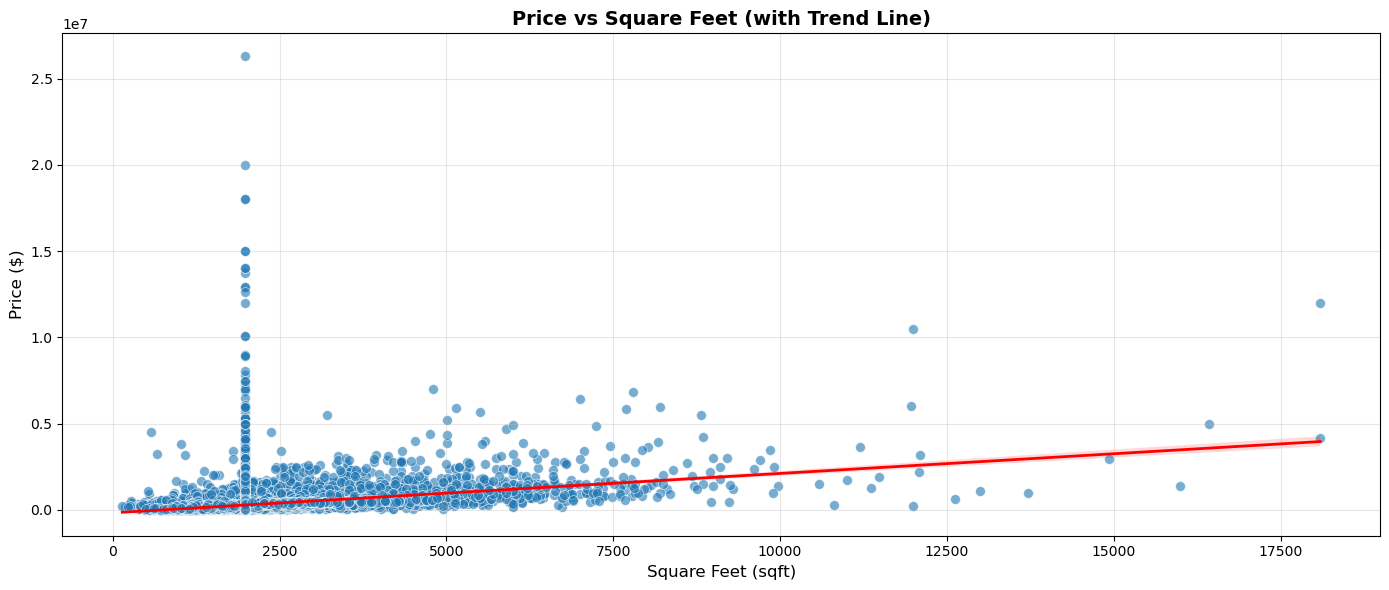


Price vs Sqft Correlation: 0.3437


In [30]:
# Scatterplot: Price vs Square Feet with trend line
plt.figure(figsize=(14, 6))
sns.scatterplot(data=listings_df, x='house_size', y='price', alpha=0.6, s=50)
sns.regplot(data=listings_df, x='house_size', y='price', scatter=False, color='red', line_kws={'linewidth': 2})
plt.title('Price vs Square Feet (with Trend Line)', fontsize=14, fontweight='bold')
plt.xlabel('Square Feet (sqft)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPrice vs Sqft Correlation: {listings_df['price'].corr(listings_df['house_size']):.4f}")


# Recommendation System Analysis

In [31]:
# Convert interaction DataFrame to a Surprise Dataset
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import SVD
from surprise.model_selection import cross_validate as surprise_cross_validate

# Detect likely user/item columns
user_col = 'user_id' if 'user_id' in user_likes_df.columns else user_likes_df.columns[0]
item_col = 'listing_id' if 'listing_id' in user_likes_df.columns else user_likes_df.columns[1]

# If there's no explicit rating column, create implicit "like" ratings = 1.0
if 'rating' not in user_likes_df.columns:
    user_likes_df = user_likes_df.copy()
    user_likes_df['rating'] = 1.0

# Prepare Surprise Reader with the observed rating range
rating_min = user_likes_df['rating'].min()
rating_max = user_likes_df['rating'].max()
reader = Reader(rating_scale=(rating_min, rating_max))

# Build Surprise dataset from DataFrame
surprise_df = user_likes_df[[user_col, item_col, 'rating']].rename(columns={user_col: 'userID', item_col: 'itemID'})
# Dataset.load_from_df expects columns in order: user, item, rating
data_surprise = Dataset.load_from_df(surprise_df[['userID', 'itemID', 'rating']], reader)

# Quick trainset stats
trainset = data_surprise.build_full_trainset()
print(f"Surprise trainset built — users: {trainset.n_users}, items: {trainset.n_items}, ratings: {trainset.n_ratings}")

# Optional: quick train/test split and small SVD cross-validation
if rating_min != rating_max:
    print("Running a quick 3-fold cross-validation with SVD (ratings are not all identical)...")
    algo = SVD()
    surprise_cross_validate(algo, data_surprise, measures=['RMSE','MAE'], cv=3, verbose=True)
else:
    print("All ratings are identical (implicit likes). To use SVD effectively, consider creating pseudo-ratings or using algorithms designed for implicit feedback.")

# Example: generate train/test sets for algorithm training/evaluation
trainset_s, testset_s = surprise_train_test_split(data_surprise, test_size=0.2, random_state=42)
print(f"Trainset size (raw ratings): {len(trainset_s.build_testset()) - len(testset_s) if hasattr(trainset_s, 'all_ratings') else 'N/A'}")
# Note: `testset_s` is a list of (uid, iid, rating) tuples ready for `algo.fit(trainset)` and `algo.test(testset)`


Surprise trainset built — users: 200, items: 17196, ratings: 27200
All ratings are identical (implicit likes). To use SVD effectively, consider creating pseudo-ratings or using algorithms designed for implicit feedback.
Trainset size (raw ratings): 16320


In [32]:
# 5-fold cross-validation on implicit like data using Surprise
# Uses SVD to learn latent factors; metrics are RMSE/MAE over the implicit ratings.
if rating_min == rating_max:
    print('All interactions share the same rating (implicit like = 1). RMSE/MAE will be low by construction; use these results for model comparisons, not absolute quality.')

kf = KFold(n_splits=5, random_state=42, shuffle=True)
algo = SVD(random_state=42)

rmse_scores, mae_scores = [], []
for fold, (trainset_cv, testset_cv) in enumerate(kf.split(data_surprise), start=1):
    algo.fit(trainset_cv)
    preds = algo.test(testset_cv)
    rmse = accuracy.rmse(preds, verbose=False)
    mae = accuracy.mae(preds, verbose=False)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    print(f'Fold {fold}: RMSE={rmse:.4f}, MAE={mae:.4f}')

print()
print(f'Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}')
print(f'Mean MAE:  {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}')


All interactions share the same rating (implicit like = 1). RMSE/MAE will be low by construction; use these results for model comparisons, not absolute quality.
Fold 1: RMSE=0.0000, MAE=0.0000
Fold 2: RMSE=0.0000, MAE=0.0000
Fold 3: RMSE=0.0000, MAE=0.0000
Fold 4: RMSE=0.0000, MAE=0.0000
Fold 5: RMSE=0.0000, MAE=0.0000

Mean RMSE: 0.0000 ± 0.0000
Mean MAE:  0.0000 ± 0.0000


## Hybrid recommender (LightFM + content)
Blends collaborative scores from LightFM with content similarity on listing attributes.

In [33]:
# Hybrid recommender combining LightFM (implicit CF) with content similarity
import warnings

# Ensure a listing_id column exists for alignment
if 'listing_id' not in listings_df.columns:
    listings_df = listings_df.reset_index().rename(columns={'index': 'listing_id'})

In [34]:
# Keep only listings present in user_likes
liked_item_ids = user_likes_df['listing_id'].unique()
listings_in_likes = listings_df[listings_df['listing_id'].isin(liked_item_ids)].copy()
missing_items = set(liked_item_ids) - set(listings_in_likes['listing_id'])
if missing_items:
    warnings.warn(f'{len(missing_items)} listing_ids in user_likes not found in listings_df; they will be skipped.')


/var/folders/mb/j2g896x179dcy7ghdww7zbh40000gn/T/ipykernel_46515/1109692074.py:6: UserWarning: 26 listing_ids in user_likes not found in listings_df; they will be skipped.
  warnings.warn(f'{len(missing_items)} listing_ids in user_likes not found in listings_df; they will be skipped.')


In [35]:
# Build numeric feature matrix for content similarity
numeric_cols = [c for c in ['price', 'bed', 'bath', 'acre_lot', 'house_size'] if c in listings_in_likes.columns]
if not numeric_cols:
    raise ValueError('No numeric listing features available for content similarity.')
features_raw = listings_in_likes[numeric_cols].fillna(0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_raw)
item_similarity = cosine_similarity(features_scaled)

In [36]:
# Fit LightFM dataset with aligned item ids
# Filter out likes that refer to items we could not align so LightFM sees only fitted ids
user_likes_aligned = user_likes_df[user_likes_df['listing_id'].isin(listings_in_likes['listing_id'])]
lf_dataset = LFDataset()
lf_dataset.fit(users=user_likes_aligned['user_id'].unique(), items=listings_in_likes['listing_id'].unique())
interactions, _ = lf_dataset.build_interactions(user_likes_aligned[['user_id', 'listing_id']].itertuples(index=False, name=None))
train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
lf_model = LightFM(no_components=32, learning_rate=0.05, loss='warp', random_state=42)
lf_model.fit(train_interactions, epochs=20, num_threads=4)

In [37]:
# Evaluate LightFM implicit ranking metrics on held-out set
test_auc = auc_score(
    lf_model,
    test_interactions=test_interactions,
    train_interactions=train_interactions,
    num_threads=4,
).mean()
test_precision = precision_at_k(
    lf_model,
    test_interactions=test_interactions,
    train_interactions=train_interactions,
    k=10,
    num_threads=4,
).mean()
test_recall = recall_at_k(
    lf_model,
    test_interactions=test_interactions,
    train_interactions=train_interactions,
    k=10,
    num_threads=4,
).mean()

print(f"LightFM WARP metrics (test set): AUC={test_auc:.4f}, Precision@10={test_precision:.4f}, Recall@10={test_recall:.4f}")

In [37]:
# Prepare mappings to go between external ids and internal indices
user_id_map, user_feature_map, item_id_map, item_feature_map = lf_dataset.mapping()
item_id_inv_map = {inner: raw for raw, inner in item_id_map.items()}
item_order = [item_id_inv_map[i] for i in range(len(item_id_inv_map))]
item_index_lookup = {raw_id: idx for idx, raw_id in enumerate(item_order)}

In [38]:
# Reorder similarity matrix to align with LightFM internal ordering
listings_aligned = listings_in_likes.set_index('listing_id').loc[item_order]
features_scaled_aligned = scaler.transform(listings_aligned[numeric_cols].fillna(0))
item_similarity = cosine_similarity(features_scaled_aligned)

In [39]:
def recommend_hybrid(user_id, top_n=10, alpha=0.6):
    """
    Recommend listings for a user by blending collaborative (LightFM) and content similarity.
    alpha controls weight of CF (alpha) vs content (1-alpha).
    Returns list of listing_ids.
    """
    if user_id not in user_id_map:
        raise ValueError(f'Unknown user_id: {user_id}')
    user_internal = user_id_map[user_id]

    # Collaborative scores from LightFM
    cf_scores = lf_model.predict(user_internal, np.arange(len(item_order)))
    cf_scores = (cf_scores - cf_scores.min()) / (cf_scores.max() - cf_scores.min() + 1e-8)

    # Content scores averaged over items the user liked
    liked_items = user_likes_df[user_likes_df['user_id'] == user_id]['listing_id']
    liked_internal = [item_index_lookup[iid] for iid in liked_items if iid in item_index_lookup]
    if liked_internal:
        content_scores = item_similarity[:, liked_internal].mean(axis=1)
    else:
        content_scores = np.zeros(len(item_order))
    content_scores = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min() + 1e-8)

    hybrid_scores = alpha * cf_scores + (1 - alpha) * content_scores

    # Exclude already liked items
    exclude = set(liked_internal)
    ranked_indices = [idx for idx in np.argsort(-hybrid_scores) if idx not in exclude]
    top_indices = ranked_indices[:top_n]
    return [item_id_inv_map[idx] for idx in top_indices]

In [40]:
# Example recommendation for the first user
sample_user = users_df['user_id'].iloc[0]
print('Hybrid recommendations for user', sample_user, ':', recommend_hybrid(sample_user, top_n=5))

Hybrid recommendations for user 1 : [10279, 17195, 20110, 13043, 27059]
